<a href="https://colab.research.google.com/github/sallihin/hdb-resale-predictor/blob/main/training-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Preparation

Data.gov.sg - Resale Flat Prices<br/>
https://data.gov.sg/dataset/resale-flat-prices


In [1]:
import pandas as pd
from sklearn import ensemble, linear_model, tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  

import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn.externals
import joblib

In [2]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/MLDV/Assessment/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

### 2. Exploratory Data Analysis

In [4]:
df.shape

(140168, 11)

In [5]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [6]:
df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

#### 2.1 Relationship between Resale Price and Block Number
Block numbers do not correlate with resale prices, and does not seem to affect the resale price. 

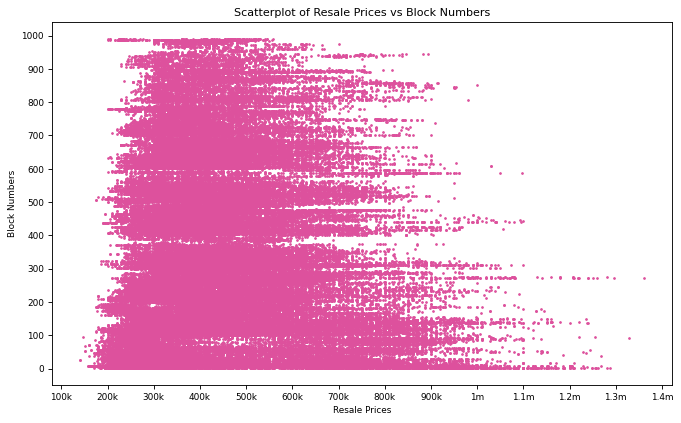

In [7]:
# Strip letters from block numbers
df['block'] = df['block'].apply(lambda x: int(re.sub("\D+", "", x)))

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
plt.scatter(df['resale_price'], df['block'], s=2, c='#dd519d')

# Decoration
plt.xlabel("Resale Prices", fontsize=8); plt.ylabel("Block Numbers", fontsize=8)
plt.title("Scatterplot of Resale Prices vs Block Numbers", fontsize=10)
plt.xticks(ticks=[100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000], 
           labels=['100k','200k','300k','400k','500k','600k','700k','800k','900k','1m','1.1m','1.2m','1.3m','1.4m'],
           fontsize=8); 
plt.yticks(ticks=[0,100,200,300,400,500,600,700,800,900,1000],
           fontsize=8)

plt.show()

#### 2.2 Relationship between Resale Price and Flat Type
Generally resale prices are higher for bigger units, although there is quite a number of outliers for 3-5 room flats due to other factors such as location and unit level. 

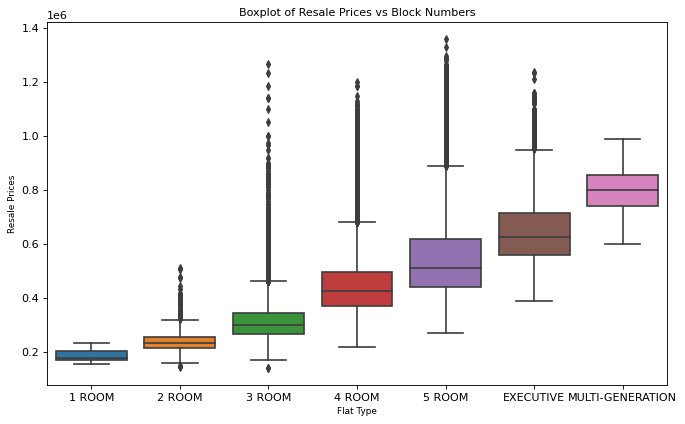

In [8]:
# Sorting 
sorted_average = df.groupby('flat_type')['resale_price'].mean().sort_values(ascending=True)

# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x=df['flat_type'], y=df['resale_price'], order=sorted_average.index)

# Decoration
plt.xlabel("Flat Type", fontsize=8); plt.ylabel("Resale Prices", fontsize=8)
plt.title("Boxplot of Resale Prices vs Block Numbers", fontsize=10)
plt.show()

#### 2.3 Relationship between Resale Price and Town
Based on the median, houses in Bukit Timah, Queenstown and Bishan generally fetch higher prices compared to other town. 

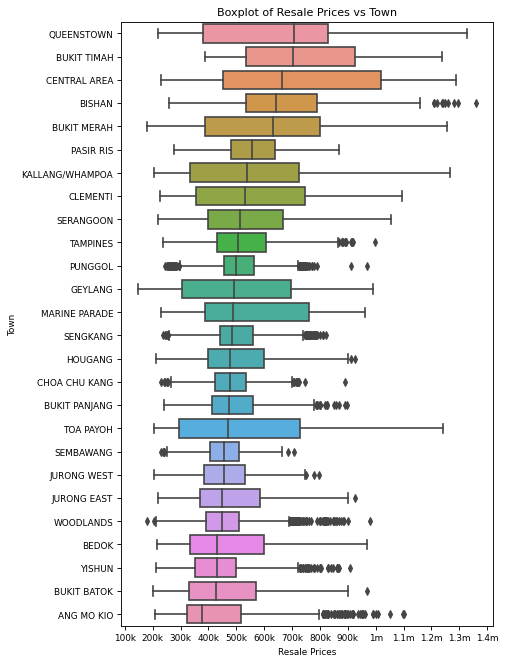

In [147]:
# Sorting 
sorted_average = df[df.month.str.contains("2021")].groupby('town')['resale_price'].median().sort_values(ascending=False)

# Draw Plot
plt.figure(figsize=(6,10), dpi= 80)
sns.boxplot(x=df['resale_price'], y=df[df.month.str.contains("2021")]['town'], order=sorted_average.index)

# Decoration
plt.xlabel("Resale Prices", fontsize=8); plt.ylabel("Town", fontsize=8)
plt.xticks(ticks=[100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000], 
           labels=['100k','200k','300k','400k','500k','600k','700k','800k','900k','1m','1.1m','1.2m','1.3m','1.4m'],
           fontsize=8); 
plt.yticks(fontsize=8)
plt.title("Boxplot of Resale Prices vs Town", fontsize=10)
plt.show()

#### 2.4 Relationship between Resale Price and Lease Commencement Date
Surprisingly there is very little correlation between the age of the flat versus the resale price. 

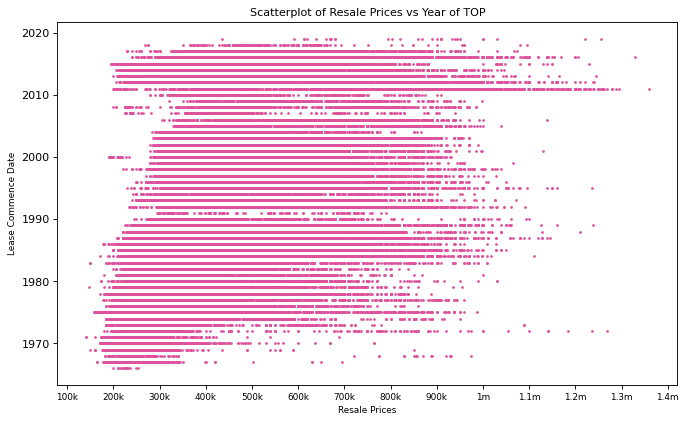

In [10]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
plt.scatter(df['resale_price'], df['lease_commence_date'], s=2, c='#dd519d')

# Decoration
plt.xlabel("Resale Prices", fontsize=8); plt.ylabel("Lease Commence Date", fontsize=8)
plt.title("Scatterplot of Resale Prices vs Year of TOP", fontsize=10)
plt.xticks(ticks=[100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000], 
           labels=['100k','200k','300k','400k','500k','600k','700k','800k','900k','1m','1.1m','1.2m','1.3m','1.4m'],
           fontsize=8); 
# plt.yticks(ticks=[1970, 1980, 1990, 2000, 2010, 2020],
#            fontsize=8)

plt.show()

However, when I filter the data by town and flat_type, it is clear that there is a relationship between the lease start date and price. 

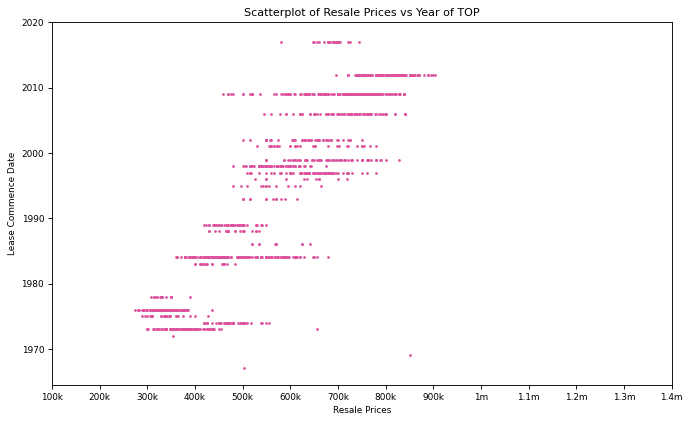

In [11]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
by_town = df[(df.town == 'TOA PAYOH') & (df.flat_type == '4 ROOM')]
plt.scatter(by_town['resale_price'], by_town['lease_commence_date'], s=2, c='#dd519d')

# Decoration
plt.xlabel("Resale Prices", fontsize=8); plt.ylabel("Lease Commence Date", fontsize=8)
plt.title("Scatterplot of Resale Prices vs Year of TOP", fontsize=10)
plt.xticks(ticks=[100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,1100000,1200000,1300000,1400000], 
           labels=['100k','200k','300k','400k','500k','600k','700k','800k','900k','1m','1.1m','1.2m','1.3m','1.4m'],
           fontsize=8); 
plt.yticks(ticks=[1970, 1980, 1990, 2000, 2010, 2020],
           fontsize=8)

plt.show()

### 3. Data Preparation


#### 3.1 Feature Selection
* As HDB flats have 99 years lease, the lease_commence_date and remaining_lease are highly correlated to each other. 
* I will also remove the block numbers and street_name to reduce noise and prevent overfitting.


In [12]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [119]:
# Convert remaining lease into months format (y*12 + m)
df.remaining_lease = df.remaining_lease.str.split(' ').str[0].astype(int) * 12 + df.remaining_lease.str.split(' ').str[2].fillna("0").astype(str).astype(int)

In [121]:
corr = df.corr()
corr.style.background_gradient(cmap="Blues")

,block,floor_area_sqm,lease_commence_date,remaining_lease,resale_price
block,1.000000,0.186897,0.247955,0.249771,-0.096471
floor_area_sqm,0.186897,1.000000,0.140554,0.142586,0.622548
lease_commence_date,0.247955,0.140554,1.000000,0.994757,0.346851
remaining_lease,0.249771,0.142586,0.994757,1.000000,0.335987
resale_price,-0.096471,0.622548,0.346851,0.335987,1.000000


In [122]:
df = df.drop(columns=['remaining_lease', 'block', 'street_name'])
df.head()

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2017-01,ANG MO KIO,2 ROOM,10 TO 12,44.0,Improved,1979,232000.0
1,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,1978,250000.0
2,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,1980,262000.0
3,2017-01,ANG MO KIO,3 ROOM,04 TO 06,68.0,New Generation,1980,265000.0
4,2017-01,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,1980,265000.0


#### 3.2 One Hot Encoding

In [123]:
features_df = pd.get_dummies(df, columns=['town', 'flat_type', 'storey_range', 'flat_model'])

In [124]:
del features_df['resale_price']
print(features_df.columns)

Index(['month', 'floor_area_sqm', 'lease_commence_date', 'town_ANG MO KIO',
       'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_3 ROOM',
       'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE',
       'flat_type_MULTI-GENERATION', 'storey_range_01 TO 03',
       'storey_range_04 TO 06', 'storey_range_07 TO 09',
       'storey_range_10 TO 12', 'storey_range_13 TO 15',
       'storey_range_16 TO 18', 'storey_range_19 TO 21',
       'storey_range_22 TO 24', 'storey_ra

In [125]:
features_df.head()

,month,floor_area_sqm,lease_commence_date,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,town_CLEMENTI,town_GEYLANG,town_HOUGANG,town_JURONG EAST,town_JURONG WEST,town_KALLANG/WHAMPOA,town_MARINE PARADE,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,storey_range_01 TO 03,storey_range_04 TO 06,storey_range_07 TO 09,storey_range_10 TO 12,storey_range_13 TO 15,storey_range_16 TO 18,storey_range_19 TO 21,storey_range_22 TO 24,storey_range_25 TO 27,storey_range_28 TO 30,storey_range_31 TO 33,storey_range_34 TO 36,storey_range_37 TO 39,storey_range_40 TO 42,storey_range_43 TO 45,storey_range_46 TO 48,storey_range_49 TO 51,flat_model_2-room,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,flat_model_Model A2,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2
0,2017-01,44.0,1979,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01,67.0,1978,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2017-01,67.0,1980,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,2017-01,68.0,1980,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2017-01,67.0,1980,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### 3.3 Data Transformation

Under the month column, I split the data into month and year of transaction and cast them as integers. 

In [126]:
features_df[['year','month']] = df.month.str.split("-",expand=True,)

In [127]:
features_df = features_df.astype({'year': 'int32', 'month': 'int32'})

In [128]:
features_df[['year', 'month']].dtypes

year     int32
month    int32
dtype: object

In [133]:
features_df[['year', 'month']].head()

,year,month
0,2017,1
1,2017,1
2,2017,1
3,2017,1
4,2017,1


### 4. Model Selection

#### 4.1 Sklearn Gradient Boosting Regressor 

In [ ]:
# Training to model using Gradient Boosting Regressor (Default Parameters)
GBR = ensemble.GradientBoostingRegressor()

X = features_df.values
y = df['resale_price'].values

# Split the data set in a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
GBR.fit(X_train, y_train)

GradientBoostingRegressor()

In [ ]:
GBR_train = GBR.predict(X_train)                 
print('Training MAE: {:,.2f}'.format(mean_absolute_error(y_train, GBR_train)))
print('Training R-squared : {:.3f}'.format(r2_score(y_train, GBR_train)))

GBR_test = GBR.predict(X_test)
print('Test MAE: {:,.2f}'.format(mean_absolute_error(y_test, GBR_test)))
print('Test R-squared : {:.3f}'.format(r2_score(y_test, GBR_test)))

Training MAE: 43,979.66
Training R-squared : 0.856
Test MAE: 43,966.47
Test R-squared : 0.855


#### 4.2 Random Forest Regressor

In [ ]:
# Training to model using Random Forest Regressor (Default Parameters)
RandomForest = ensemble.RandomForestRegressor()

X = features_df.values
y = df['resale_price'].values

# Split the data set in a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
RandomForest.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
RF_train = RandomForest.predict(X_train)                 
print('Training MAE: {:,.2f}'.format(mean_absolute_error(y_train, RF_train)))
print('Training R-squared : {:.3f}'.format(r2_score(y_train, RF_train)))

RF_test = RandomForest.predict(X_test)
print('Test MAE: {:,.2f}'.format(mean_absolute_error(y_test, RF_test)))
print('Test R-squared : {:.3f}'.format(r2_score(y_test, RF_test)))

Training MAE: 9,057.40
Training R-squared : 0.993
Test MAE: 21,052.86
Test R-squared : 0.961


#### 4.3 Linear Regression 

In [ ]:
# Training to model using Random Forest Regressor (Default Parameters)
LR = linear_model.LinearRegression()

X = features_df.values
y = df['resale_price'].values

# Split the data set in a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
LR.fit(X_train, y_train)

LinearRegression()

In [ ]:
LR_train = LR.predict(X_train)                 
print('Training MAE: {:,.2f}'.format(mean_absolute_error(y_train, LR_train)))
print('Training R-squared : {:.3f}'.format(r2_score(y_train, LR_train)))

LR_test = LR.predict(X_test)
print('Test MAE: {:,.2f}'.format(mean_absolute_error(y_test, LR_test)))
print('Test R-squared : {:.3f}'.format(r2_score(y_test, LR_test)))

Training MAE: 45,636.96
Training R-squared : 0.863
Test MAE: 45,870.70
Test R-squared : 0.860


#### 4.4 Decision Tree Regressor

In [ ]:
# Training to model using Random Forest Regressor (Default Parameters)
DTR = tree.DecisionTreeRegressor()

X = features_df.values
y = df['resale_price'].values

# Split the data set in a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
DTR.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
DTR_train = LR.predict(X_train)                 
print('Training MAE: {:,.2f}'.format(mean_absolute_error(y_train, DTR_train)))
print('Training R-squared : {:.3f}'.format(r2_score(y_train, DTR_train)))

DTR_test = LR.predict(X_test)
print('Test MAE: {:,.2f}'.format(mean_absolute_error(y_test, DTR_test)))
print('Test R-squared : {:.3f}'.format(r2_score(y_test, DTR_test)))

Training MAE: 45,636.96
Training R-squared : 0.863
Test MAE: 45,870.70
Test R-squared : 0.860


#### 5. Hyperparameter Tuning

Abandoned GridSearch as it was taking too long and exceeded the runtime limit on Google Colab despite upgrading to a Pro+ account. 

In [ ]:
# Define the grid search we want to run. Run it with four cpus in parallel.
# gs_cv = GridSearchCV(model, param_grid, n_jobs=-1, verbose=3)
# gs_cv.fit(X_train, y_train)

Used RandomSearchCV instead. Total training time was approximately 10 hours. 

##### 5.1 Random Forest Tuning

In [ ]:
model = ensemble.RandomForestRegressor()
param_grid = {
    'n_estimators' : [200,500,1000],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'max_features': ['auto','sqrt','log2'],
    'max_depth': [10, 50, 100, None],
    'bootstrap': [True, False]
}

In [ ]:
ht_model = RandomizedSearchCV(model, param_grid, n_iter = 20, verbose=3, random_state=42)
ht_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.946 total time= 2.0min
[CV 2/5] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.946 total time= 2.4min
[CV 3/5] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.947 total time= 2.6min
[CV 4/5] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.946 total time= 2.7min
[CV 5/5] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.947 total time= 2.6min
[CV 1/5] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=0.951 total time=  54.3s

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 50, 100, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 500, 1000]},
                   random_state=42, verbose=3)

In [ ]:
print(ht_model.best_params_)

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [ ]:
# Training to model using Random Forest Regressor (Default Parameters)
RandomForest_Tuned = ensemble.RandomForestRegressor(n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth=None, bootstrap=True)

X = features_df.values
y = df['resale_price'].values

# Split the data set in a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
RandomForest_Tuned.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=5, n_estimators=500)

In [ ]:
RFT_train = RandomForest_Tuned.predict(X_train)                 
print('Training MAE: {:,.2f}'.format(mean_absolute_error(y_train, RFT_train)))
print('Training R-squared : {:.3f}'.format(r2_score(y_train, RFT_train)))

RFT_test = RandomForest_Tuned.predict(X_test)
print('Test MAE: {:,.2f}'.format(mean_absolute_error(y_test, RFT_test)))
print('Test R-squared : {:.3f}'.format(r2_score(y_test, RFT_test)))

Training MAE: 12,181.75
Training R-squared : 0.988
Test MAE: 21,350.58
Test R-squared : 0.962


In [ ]:
feature_labels = ['month', 'floor_area_sqm', 'lease_commence_date', 'town_ANG MO KIO',
       'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_3 ROOM',
       'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE',
       'flat_type_MULTI-GENERATION', 'storey_range_01 TO 03',
       'storey_range_04 TO 06', 'storey_range_07 TO 09',
       'storey_range_10 TO 12', 'storey_range_13 TO 15',
       'storey_range_16 TO 18', 'storey_range_19 TO 21',
       'storey_range_22 TO 24', 'storey_range_25 TO 27',
       'storey_range_28 TO 30', 'storey_range_31 TO 33',
       'storey_range_34 TO 36', 'storey_range_37 TO 39',
       'storey_range_40 TO 42', 'storey_range_43 TO 45',
       'storey_range_46 TO 48', 'storey_range_49 TO 51', 'flat_model_2-room',
       'flat_model_Adjoined flat', 'flat_model_Apartment', 'flat_model_DBSS',
       'flat_model_Improved', 'flat_model_Improved-Maisonette',
       'flat_model_Maisonette', 'flat_model_Model A',
       'flat_model_Model A-Maisonette', 'flat_model_Model A2',
       'flat_model_Multi Generation', 'flat_model_New Generation',
       'flat_model_Premium Apartment', 'flat_model_Premium Apartment Loft',
       'flat_model_Premium Maisonette', 'flat_model_Simplified',
       'flat_model_Standard', 'flat_model_Terrace', 'flat_model_Type S1',
       'flat_model_Type S2','year']
importance = RandomForest_Tuned.feature_importances_       
feature_indexes_by_importance = importance.argsort()

# Print each feature label, from most important to least important (reverse order)
for i in reversed(feature_indexes_by_importance[-5:]):
    print("{} - {:.2f}%".format(feature_labels[i], (importance[i] * 100.0)))

floor_area_sqm - 37.10%
lease_commence_date - 13.26%
flat_type_4 ROOM - 10.80%
town_BUKIT MERAH - 5.36%
town_QUEENSTOWN - 4.56%


RandomForest did not show much improvement after hyperparameter tuning. Training data is almost perfect at 99% suggesting the data may have overfitting.

##### 5.2 Gradient Boosting Regressor Tuning

In [ ]:
# Training to model using Grdient Boosting Regressor 
model = ensemble.GradientBoostingRegressor()

# Setting the parameter range for testing
param_grid = {
    'n_estimators': [1000, 3000],
    'max_depth': [4, 6],
    'min_samples_leaf': [9, 17],
    'learning_rate': [0.1, 0.01],
    'max_features': [1.0, 0.1],
    'loss': ['squared_error', 'huber']
}

In [ ]:
ht_model2 = RandomizedSearchCV(model, param_grid, n_iter = 20, verbose=3, random_state=42)
ht_model2.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=0.01, loss=huber, max_depth=4, max_features=0.1, min_samples_leaf=9, n_estimators=1000;, score=0.852 total time=  59.7s
[CV 2/5] END learning_rate=0.01, loss=huber, max_depth=4, max_features=0.1, min_samples_leaf=9, n_estimators=1000;, score=0.854 total time= 1.0min
[CV 3/5] END learning_rate=0.01, loss=huber, max_depth=4, max_features=0.1, min_samples_leaf=9, n_estimators=1000;, score=0.852 total time= 1.0min
[CV 4/5] END learning_rate=0.01, loss=huber, max_depth=4, max_features=0.1, min_samples_leaf=9, n_estimators=1000;, score=0.845 total time= 1.0min
[CV 5/5] END learning_rate=0.01, loss=huber, max_depth=4, max_features=0.1, min_samples_leaf=9, n_estimators=1000;, score=0.848 total time= 1.0min
[CV 1/5] END learning_rate=0.01, loss=huber, max_depth=6, max_features=1.0, min_samples_leaf=17, n_estimators=1000;, score=0.922 total time= 5.3min
[CV 2/5] END learning_rate=0.01, loss=huber, max_depth=

RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=20,
                   param_distributions={'learning_rate': [0.1, 0.01],
                                        'loss': ['squared_error', 'huber'],
                                        'max_depth': [4, 6],
                                        'max_features': [1.0, 0.1],
                                        'min_samples_leaf': [9, 17],
                                        'n_estimators': [1000, 3000]},
                   random_state=42, verbose=3)

In [ ]:
print(ht_model2.best_params_)

{'n_estimators': 3000, 'min_samples_leaf': 9, 'max_features': 1.0, 'max_depth': 6, 'loss': 'squared_error', 'learning_rate': 0.1}


In [ ]:
# Training to model using Random Forest Regressor (Default Parameters)
GBR_Tuned = ensemble.GradientBoostingRegressor(n_estimators=3000, min_samples_leaf=9, max_features=1, max_depth=6, loss='squared_error', learning_rate=0.1)

X = features_df.values
y = df['resale_price'].values

# Split the data set in a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
GBR_Tuned.fit(X_train, y_train)



GradientBoostingRegressor(max_depth=6, max_features=1, min_samples_leaf=9,
                          n_estimators=3000)

In [ ]:
GBRT_train = GBR_Tuned.predict(X_train)                 
print('Training MAE: {:,.2f}'.format(mean_absolute_error(y_train, GBRT_train)))
print('Training R-squared : {:.3f}'.format(r2_score(y_train, GBRT_train)))

GBRT_test = GBR_Tuned.predict(X_test)
print('Test MAE: {:,.2f}'.format(mean_absolute_error(y_test, GBRT_test)))
print('Test R-squared : {:.3f}'.format(r2_score(y_test, GBRT_test)))

Training MAE: 23,786.91
Training R-squared : 0.957
Test MAE: 25,347.33
Test R-squared : 0.950


In [ ]:
feature_labels = ['month', 'floor_area_sqm', 'lease_commence_date', 'town_ANG MO KIO',
       'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_type_1 ROOM', 'flat_type_2 ROOM', 'flat_type_3 ROOM',
       'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE',
       'flat_type_MULTI-GENERATION', 'storey_range_01 TO 03',
       'storey_range_04 TO 06', 'storey_range_07 TO 09',
       'storey_range_10 TO 12', 'storey_range_13 TO 15',
       'storey_range_16 TO 18', 'storey_range_19 TO 21',
       'storey_range_22 TO 24', 'storey_range_25 TO 27',
       'storey_range_28 TO 30', 'storey_range_31 TO 33',
       'storey_range_34 TO 36', 'storey_range_37 TO 39',
       'storey_range_40 TO 42', 'storey_range_43 TO 45',
       'storey_range_46 TO 48', 'storey_range_49 TO 51', 'flat_model_2-room',
       'flat_model_Adjoined flat', 'flat_model_Apartment', 'flat_model_DBSS',
       'flat_model_Improved', 'flat_model_Improved-Maisonette',
       'flat_model_Maisonette', 'flat_model_Model A',
       'flat_model_Model A-Maisonette', 'flat_model_Model A2',
       'flat_model_Multi Generation', 'flat_model_New Generation',
       'flat_model_Premium Apartment', 'flat_model_Premium Apartment Loft',
       'flat_model_Premium Maisonette', 'flat_model_Simplified',
       'flat_model_Standard', 'flat_model_Terrace', 'flat_model_Type S1',
       'flat_model_Type S2','year']

importance = GBR_Tuned.feature_importances_       
feature_indexes_by_importance = importance.argsort()

# Print each feature label, from most important to least important (reverse order)
for i in reversed(feature_indexes_by_importance[-10:]):
    print("{} - {:.2f}%".format(feature_labels[i], (importance[i] * 100.0)))

floor_area_sqm - 17.55%
flat_type_3 ROOM - 11.74%
lease_commence_date - 9.31%
flat_type_EXECUTIVE - 4.29%
flat_model_DBSS - 3.97%
town_BUKIT MERAH - 3.66%
flat_type_5 ROOM - 3.57%
flat_model_Maisonette - 3.37%
year - 2.79%
town_QUEENSTOWN - 2.70%


In [ ]:
# Save the trained model to a file so we can use it other programs 
joblib.dump(GBR_Tuned, '/content/drive/MyDrive/MLDV/Assessment/trained_hdb_resale_estimator.pkl')

['/content/drive/MyDrive/MLDV/Assessment/trained_hdb_resale_estimator.pkl']

### 5. Data Validation
I tested the data with some home prices on PropertyGuru to determine its accuracy in predicting today's prices. 

In [ ]:
house_to_predict = [
  1, # month you want to buy 
  133, # floor_area_sqm 
  1984, # lease_commence_date 

  # Select 1 Town 
  0, # ANG MO KIO
  0, # BEDOK
  0, # BISHAN 
  0, # BUKIT BATOK 
  0, # BUKIT MERAH
  0, # BUKIT PANJANG 
  0, # BUKIT TIMAH 
  0, # CENTRAL AREA
  0, # CHOA CHU KANG 
  0, # CLEMENTI 
  0, # GEYLANG 
  0, # HOUGANG
  0, # JURONG EAST 
  0, # JURONG WEST 
  0, # KALLANG/WHAMPOA
  0, # MARINE PARADE 
  0, # PASIR RIS 
  0, # PUNGGOL
  0, # QUEENSTOWN 
  0, # SEMBAWANG 
  0, # SENGKANG 
  0, # SERANGOON
  1, # TAMPINES 
  0, # TOA PAYOH 
  0, # WOODLANDS 
  0, # YISHUN

  # Select 1 Flat Type
  0, # 1 ROOM 
  0, # 2 ROOM 
  0, # 3 ROOM
  0, # 4 ROOM 
  1, # 5 ROOM 
  0, # EXECUTIVE
  0, # MULTI-GENERATION 

  # Select Floor
  0, # 01 TO 03
  1, # 04 TO 06 
  0, # 07 TO 09
  0, # 10 TO 12 
  0, # 13 TO 15
  0, # 16 TO 18 
  0, # 19 TO 21
  0, # 22 TO 24 
  0, # 25 TO 27
  0, # 28 TO 30 
  0, # 31 TO 33
  0, # 34 TO 36 
  0, # 37 TO 39
  0, # 40 TO 42 
  0, # 43 TO 45
  0, # 46 TO 48 
  0, # 49 TO 51 

  # Flat Model
  0, # 2-room
  0, # Adjoined flat 
  0, # Apartment 
  0, # DBSS
  0, # Improved 
  0, # Improved-Maisonette
  0, # Maisonette 
  1, # Model A
  0, # Model A-Maisonette 
  0, # Model A2
  0, # Multi Generation 
  0, # New Generation
  0, # Premium Apartment 
  0, # Premium Apartment Loft
  0, # Premium Maisonette 
  0, # Simplified
  0, # Standard 
  0, # Terrace 
  0, # Type S1
  0, # Type S2

  2022 # year you want to buy
]

Comparing the results from [HDB Resale Prices checklist](https://services2.hdb.gov.sg/webapp/BB33RTIS/BB33PReslTrans.jsp), a flat with the above features has a listed price was $638,000.00 which is within the acceptable limits of our test data. 

In [ ]:
predicted_value = GBR_Tuned.predict([house_to_predict])[0]
print("This house has an estimated value of ${:,.2f}".format(predicted_value))

This house has an estimated value of $630,525.32


### 6. Conclusion

While **Random Forest** has a higher accuracy in both the training and test data, it seems like there is a possibility of overfitting due to the low bias in training data and high variance in the test data. Hyperparamter tuning using RandomSearchCV did not significantly improve the accuracy nor generalization of the model, resulting in a very inaccurate prediction. 

I also tested the **Gradient Boosting Regressor**, as it has a well balanced model with the smallest difference between training and test data. I optimized the parameters using RandomSearchCV and saw a 10% increase in accuracy, with the model prediction performing more accurately than Random Forest. 

The top 3 features that determines the prices seems to be the floor area, lease date and flat type. 


##### **Limitations**

* The model does not account for [cooling measures](https://www.mnd.gov.sg/newsroom/press-releases/view/measures-to-cool-the-property-market) announced by the government on December 15, 2021. 
* It also does not factor in other nuances such as the condition of the flat, renovations, amenities etc
* There could also be other factors and natural forces affecting the price of resale flats, such as the current market conditions and the Covid-19 pandemic. 


##### **Web Application**
Try out the model at https://hdb-resale-predictor.herokuapp.com/ 

